In [1]:
%load_ext autoreload
%autoreload 2

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dash
from dash.dependencies import Input, Output
from dash import dcc, html
import plotly.graph_objs as go
import pickle
import os

# import custom module
import scrubbing as scrb

In [ ]:
# How to handle deleting existing data when re-running the whole pipeline?

# Load Data From EIA, NOAA, and BLS

In [3]:
%run get_data.py "2018-06-19" "2024-02-16"
# run python script to load data and save to Datasets/prelim.csv

Requesting energy demand data from EIA over 10 requests
Requesting energy price data from EIA
Requesting Weather Data from NOAA
Requesting data from Bereau of Labor Statistics
All data loaded successfully. Saving preliminary dataset to Datasets/preliminary.csv
Preliminary dataset saved.


# Show Summary Information about Preliminary Dataset

In [4]:
# display summary of dataset
preliminary_data = pd.read_csv(r"Datasets/preliminary.csv", index_col=0)
desciptions = preliminary_data.describe().round(2)
cols_per_table = 6
for n in range(0,int(np.ceil(desciptions.shape[1]/cols_per_table))):
    # print(n*cols_per_table, (n*cols_per_table)+cols_per_table)
    display(desciptions.iloc[:,n*cols_per_table : (n*cols_per_table)+cols_per_table])

,Energy Demand (MWH),HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyStationPressure
count,49627.00,47372.00,47381.00,44674.00,47372.00,47171.00
mean,5708.19,43.11,57.21,0.01,62.31,29.88
std,1224.60,19.12,16.84,0.05,19.59,0.23
min,0.00,-17.00,2.00,0.00,7.00,28.71
25%,4815.00,28.00,44.00,0.00,47.00,29.73
50%,5544.00,45.00,58.00,0.00,61.00,29.88
75%,6284.00,60.00,72.00,0.00,78.00,30.04
max,11069.00,79.00,95.00,3.47,100.00,30.59


,HourlyWetBulbTemperature,HourlyWindSpeed,Energy Price (cents/KWH),CPI-U,Unemployment Rate,Unemployment Level
count,47145.00,40215.00,47779.00,49266.00,48523.00,48523.00
mean,50.52,4.99,19.84,295.43,7.14,293521.00
std,15.63,19.62,1.96,17.72,3.97,156851.54
min,0.00,0.00,16.85,273.84,3.30,140697.00
25%,38.00,3.00,18.38,279.47,4.30,183574.00
50%,51.00,5.00,19.29,289.49,5.40,222617.00
75%,64.00,7.00,21.20,313.88,9.90,409961.00
max,81.00,2237.00,23.95,328.01,21.50,836383.00


,Employment Level,Labor Force Level,Employment Population Ratio,Labor Force Participation,Civilian Noninstitutional Population,Payroll Employment
count,48523.00,48523.00,48523.00,48523.00,48523.00,48523.00
mean,3853778.76,4147299.76,55.76,59.99,6915693.82,4465.78
std,238814.31,103952.79,3.58,1.72,174856.23,260.26
min,3046955.00,3707014.00,42.90,52.00,6641170.00,3748.60
25%,3712627.00,4085159.00,54.30,59.60,6746032.00,4225.70
50%,3897289.00,4122588.00,57.40,60.10,6918967.00,4563.10
75%,4076332.00,4254770.00,57.90,60.90,7107466.00,4661.90
max,4141201.00,4322118.00,59.10,62.80,7131615.00,4756.70


# Split dataset into training and holdout sets

In [22]:
prelim_training_data = scrb.split_preliminary_dataset(prelim_dataset=preliminary_data)

# Produce Raw Time Series Plots

In [ ]:
scrb.raw_time_series_plots(prelim_training_data=prelim_training_data)

# Transform Variables

In [23]:
transformed_data = scrb.transform_variables(prelim_training_data)

### Identify Outliers and Produce Plots with Outliers Identified

In [30]:
# identify outliers
outliers_removed_data = scrb.identify_outliers(transformed_training_data=transformed_data)

/home/tobi/Desktop/Capstone/EnergyDemandForecasting/scrubbing.py:271: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/tobi/Desktop/Capstone/EnergyDemandForecasting/scrubbing.py:271: RuntimeWarning:

invalid value encountered in scalar divide



In [19]:
# Define available options for the dropdown menu
path_to_plots = r"Plotly Figures/Outlier Detection"
dropdown_options = []
for variable in preliminary_data.columns:
    file_variable = variable.replace(r"/", "-")
    dropdown_options.append({"label":variable, "value":"{}/{}.pkl".format(path_to_plots, file_variable)})


# Initialize the Dash app
app = dash.Dash(__name__)


# Layout of the Dash app
app.layout = html.Div(children=[
    dcc.Dropdown(
        id='figure-dropdown',
        options=dropdown_options,
        value=dropdown_options[0]['value']  # Default value
    ),
    html.Div([], id='output-graph')
])

# Callback to update the displayed graph based on dropdown selection
@app.callback(
    Output('output-graph', 'children'),
    [Input('figure-dropdown', 'value')]
)
def update_graph(selected_figure):
    # Unpickle the selected figure
    with open(selected_figure, 'rb') as f:
        figure_data = pickle.load(f)

    # Create the Plotly figure
    figure = go.Figure(figure_data)

    # Convert the Plotly figure to a Dash graph object
    graph = dcc.Graph(
        id='example-graph',
        figure=figure
    )

    return graph

# Run the Dash app
if __name__ == '__main__':
    app.run(debug=True, host='127.0.0.1')


# Remove Outliers, Impute Missing Values, Transform Variables

In [124]:
# run function to clean dataset
clean_data = scrb.impute_missing_values(outliers_removed_data=outliers_removed_data)


Interpolating for variable Energy Demand (MWH)


22:16:12 - cmdstanpy - INFO - Chain [1] start processing
22:16:14 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyDewPointTemperature


22:16:20 - cmdstanpy - INFO - Chain [1] start processing
22:16:22 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyDryBulbTemperature


22:16:28 - cmdstanpy - INFO - Chain [1] start processing
22:16:30 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyRelativeHumidity


22:16:36 - cmdstanpy - INFO - Chain [1] start processing
22:16:38 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyStationPressure


22:16:44 - cmdstanpy - INFO - Chain [1] start processing
22:16:46 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyWetBulbTemperature


22:16:52 - cmdstanpy - INFO - Chain [1] start processing
22:16:54 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyWindSpeed


22:17:00 - cmdstanpy - INFO - Chain [1] start processing
22:17:02 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Energy Price (cents/KWH)


22:17:08 - cmdstanpy - INFO - Chain [1] start processing
22:17:19 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable CPI-U


22:17:25 - cmdstanpy - INFO - Chain [1] start processing
22:17:47 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Unemployment Rate


22:17:53 - cmdstanpy - INFO - Chain [1] start processing
22:18:06 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Unemployment Level


22:18:12 - cmdstanpy - INFO - Chain [1] start processing
22:18:35 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Employment Level


22:18:41 - cmdstanpy - INFO - Chain [1] start processing
22:18:55 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Labor Force Level


22:19:13 - cmdstanpy - INFO - Chain [1] start processing
22:19:33 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Employment Population Ratio


22:19:39 - cmdstanpy - INFO - Chain [1] start processing
22:19:53 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Labor Force Participation


22:19:58 - cmdstanpy - INFO - Chain [1] start processing
22:20:19 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Civilian Noninstitutional Population


22:20:24 - cmdstanpy - INFO - Chain [1] start processing
22:20:42 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Payroll Employment


22:20:47 - cmdstanpy - INFO - Chain [1] start processing
22:21:01 - cmdstanpy - INFO - Chain [1] done processing


# Show Distributions for each Variable

In [ ]:
# run function to produce distribution plots
scrb.distribution_plots(clean_training_data=clean_data)

In [48]:
# dash app to show one distribution plot at a time
# Define available options for the dropdown menu
import base64
from PIL import Image
path_to_plots = r"Static Visuals/Distributions"
dropdown_options = []
for variable in preliminary_data.columns:
    file_variable = variable.replace(r"/", "-")
    dropdown_options.append({"label":variable, "value":"{}/{}.png".format(path_to_plots, file_variable)})

# Initialize the Dash app
app = dash.Dash(__name__)

# Resize images to this width
IMAGE_WIDTH = 750

# Layout of the Dash app
app.layout = html.Div([
    dcc.Dropdown(
        id='image-dropdown',
        options=dropdown_options,
        value=dropdown_options[0]['value']  # Default value
    ),
    html.Div(id='output-image')
])

# Callback to update the displayed image based on dropdown selection
@app.callback(
    Output('output-image', 'children'),
    [Input('image-dropdown', 'value')]
)
def update_image(selected_image):
    # Read the image file
    with open(selected_image, 'rb') as f:
        img = Image.open(f)
        # Resize the image while preserving aspect ratio
        img.thumbnail((IMAGE_WIDTH, IMAGE_WIDTH))
        # Convert the image to RGBA if it's not already in that mode
        img = img.convert('RGBA')
        # Create a white background image to place the resized image on
        bg = Image.new('RGBA', (IMAGE_WIDTH, IMAGE_WIDTH), (255, 255, 255, 255))
        bg.paste(img, (int((IMAGE_WIDTH - img.width) / 2), int((IMAGE_WIDTH - img.height) / 2)), img)
        # Save the resized and centered image to a temporary file
        temp_image_path = 'temp.png'
        bg.save(temp_image_path)

    # Encode the resized image to base64 format
    with open(temp_image_path, 'rb') as f:
        encoded_image = base64.b64encode(f.read()).decode('utf-8')

    # Create an HTML img element with the encoded image
    image_element = html.Img(src='data:image/png;base64,{}'.format(encoded_image))

    # Delete the temporary image file
    os.remove(temp_image_path)

    return image_element

# Run the Dash app
if __name__ == '__main__':
    app.run(debug=True, host='127.0.0.1')

---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
File ~/miniforge3/envs/Capstone/lib/python3.11/site-packages/IPython/core/interactiveshell.py:310, in _modified_open(
    file='Static Visuals/Distributions/HourlyPrecipitation.png',
    *args=('rb',),
    **kwargs={}
)
    303 if file in {0, 1, 2}:
    304     raise ValueError(
    305         f"IPython won't let you open fd={file} by default "
    306         "as it is likely to crash IPython. If you know what you are doing, "
    307         "you can use builtins' open."
    308     )
--> 310 return io_open(file, *args, **kwargs)
        io_open = <built-in function open>
        file = 'Static Visuals/Distributions/HourlyPrecipitation.png'
        args = ('rb',)
        kwargs = {}

FileNotFoundError: [Errno 2] No such file or directory: 'Static Visuals/Distributions/HourlyPrecipitation.png'



# Show Scatter Plot between each Variable and Energy Demand

In [125]:
# run function to produce correlation plots
scrb.scatterplots(clean_training_data=clean_data)


TypeError: can only concatenate str (not "float") to str

In [126]:
# dash app to show one scatter plot at a time
# dash app to show one distribution plot at a time
# Define available options for the dropdown menu
import base64
from PIL import Image
path_to_plots = r"Static Visuals/Scatterplots"
dropdown_options = []
for variable in preliminary_data.columns:
    file_variable = variable.replace(r"/", "-")
    dropdown_options.append({"label":variable, "value":"{}/{}.png".format(path_to_plots, file_variable)})

# Initialize the Dash app
app = dash.Dash(__name__)

# Resize images to this width
IMAGE_WIDTH = 750

# Layout of the Dash app
app.layout = html.Div([
    dcc.Dropdown(
        id='image-dropdown',
        options=dropdown_options,
        value=dropdown_options[0]['value']  # Default value
    ),
    html.Div(id='output-image')
])

# Callback to update the displayed image based on dropdown selection
@app.callback(
    Output('output-image', 'children'),
    [Input('image-dropdown', 'value')]
)
def update_image(selected_image):
    # Read the image file
    with open(selected_image, 'rb') as f:
        img = Image.open(f)
        # Resize the image while preserving aspect ratio
        img.thumbnail((IMAGE_WIDTH, IMAGE_WIDTH))
        # Convert the image to RGBA if it's not already in that mode
        img = img.convert('RGBA')
        # Create a white background image to place the resized image on
        bg = Image.new('RGBA', (IMAGE_WIDTH, IMAGE_WIDTH), (255, 255, 255, 255))
        bg.paste(img, (int((IMAGE_WIDTH - img.width) / 2), int((IMAGE_WIDTH - img.height) / 2)), img)
        # Save the resized and centered image to a temporary file
        temp_image_path = 'temp.png'
        bg.save(temp_image_path)

    # Encode the resized image to base64 format
    with open(temp_image_path, 'rb') as f:
        encoded_image = base64.b64encode(f.read()).decode('utf-8')

    # Create an HTML img element with the encoded image
    image_element = html.Img(src='data:image/png;base64,{}'.format(encoded_image))

    # Delete the temporary image file
    os.remove(temp_image_path)

    return image_element

# Run the Dash app
if __name__ == '__main__':
    app.run(debug=True, host='127.0.0.1')

---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
File ~/miniforge3/envs/Capstone/lib/python3.11/site-packages/IPython/core/interactiveshell.py:310, in _modified_open(
    file='temp.png',
    *args=('rb',),
    **kwargs={}
)
    303 if file in {0, 1, 2}:
    304     raise ValueError(
    305         f"IPython won't let you open fd={file} by default "
    306         "as it is likely to crash IPython. If you know what you are doing, "
    307         "you can use builtins' open."
    308     )
--> 310 return io_open(file, *args, **kwargs)
        io_open = <built-in function open>
        file = 'temp.png'
        args = ('rb',)
        kwargs = {}

FileNotFoundError: [Errno 2] No such file or directory: 'temp.png'



# Show Time Series Decomposition for each Variable

In [118]:
# run function to produce (and save) time series decomposition plots
scrb.time_series_decompositions(clean_training_data=clean_data)

# dash app to show one time series decomposition plot at a time

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-

In [123]:
# Define available options for the dropdown menu
import base64
from PIL import Image
path_to_plots = r"Static Visuals/Decompositions"
dropdown_options = []
for variable in prelim_training_data.select_dtypes("number").columns:
    file_variable = variable.replace(r"/", "-")
    dropdown_options.append({"label":variable, "value":"{}/{}.png".format(path_to_plots, file_variable)})

# Initialize the Dash app
app = dash.Dash(__name__)

# Resize images to this width
IMAGE_WIDTH = 750

# Layout of the Dash app
app.layout = html.Div([
    dcc.Dropdown(
        id='image-dropdown',
        options=dropdown_options,
        value=dropdown_options[0]['value']  # Default value
    ),
    html.Div(id='output-image', style={'height': '800px'})
])

# Callback to update the displayed image based on dropdown selection
@app.callback(
    Output('output-image', 'children'),
    [Input('image-dropdown', 'value')]
)
def update_image(selected_image):
    # Read the image file
    with open(selected_image, 'rb') as f:
        img = Image.open(f)
        # Resize the image while preserving aspect ratio
        img.thumbnail((IMAGE_WIDTH, IMAGE_WIDTH))
        # Convert the image to RGBA if it's not already in that mode
        img = img.convert('RGBA')
        # Create a white background image to place the resized image on
        bg = Image.new('RGBA', (IMAGE_WIDTH, IMAGE_WIDTH), (255, 255, 255, 255))
        bg.paste(img, (int((IMAGE_WIDTH - img.width) / 2), int((IMAGE_WIDTH - img.height) / 2)), img)
        # Save the resized and centered image to a temporary file
        temp_image_path = 'temp.png'
        bg.save(temp_image_path)

    # Encode the resized image to base64 format
    with open(temp_image_path, 'rb') as f:
        encoded_image = base64.b64encode(f.read()).decode('utf-8')

    # Create an HTML img element with the encoded image
    image_element = html.Img(src='data:image/png;base64,{}'.format(encoded_image))

    # Delete the temporary image file
    os.remove(temp_image_path)

    return image_element

# Run the Dash app
if __name__ == '__main__':
    app.run(debug=True, host='127.0.0.1')

# Fit and Tune VARMA-GARCH Model on Prophet residuals

In [ ]:
# run function to tune VARMA-GARCH model and return best set of hyperparameters
# run function to fit (and save) VARMA-GARCH model using best set of hyperparameters

# dash app to show results?

In [51]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

data = outliers_removed_data.copy()
# Example data
variable = "Energy Demand (MWH)"
df = outliers_removed_data[[variable]].reset_index().rename(columns={"index":"ds", variable:"y"})

# Create and fit Prophet model
model = Prophet(seasonality_mode='additive')
model.fit(df)

21:06:36 - cmdstanpy - INFO - Chain [1] start processing
21:06:49 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
display(df['y'].values - forecasts["yhat"].values)

array([1097.79760612, 1031.10947482, 1002.06386487, ...,  355.57183045,
        337.38301839,  292.14943932])

In [83]:
forecasts = model.predict(df)
forecasts.index = pd.to_datetime(outliers_removed_data.index)
forecasts['y'] = df['y'].values
forecasts["residual"] = df["y"].values - forecasts["yhat"].values

In [90]:
display((forecasts==-np.inf).sum())

ds                            0
trend                         0
yhat_lower                    0
yhat_upper                    0
trend_lower                   0
trend_upper                   0
additive_terms                0
additive_terms_lower          0
additive_terms_upper          0
daily                         0
daily_lower                   0
daily_upper                   0
weekly                        0
weekly_lower                  0
weekly_upper                  0
yearly                        0
yearly_lower                  0
yearly_upper                  0
multiplicative_terms          0
multiplicative_terms_lower    0
multiplicative_terms_upper    0
yhat                          0
y                             0
residual                      0
dtype: int64

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-

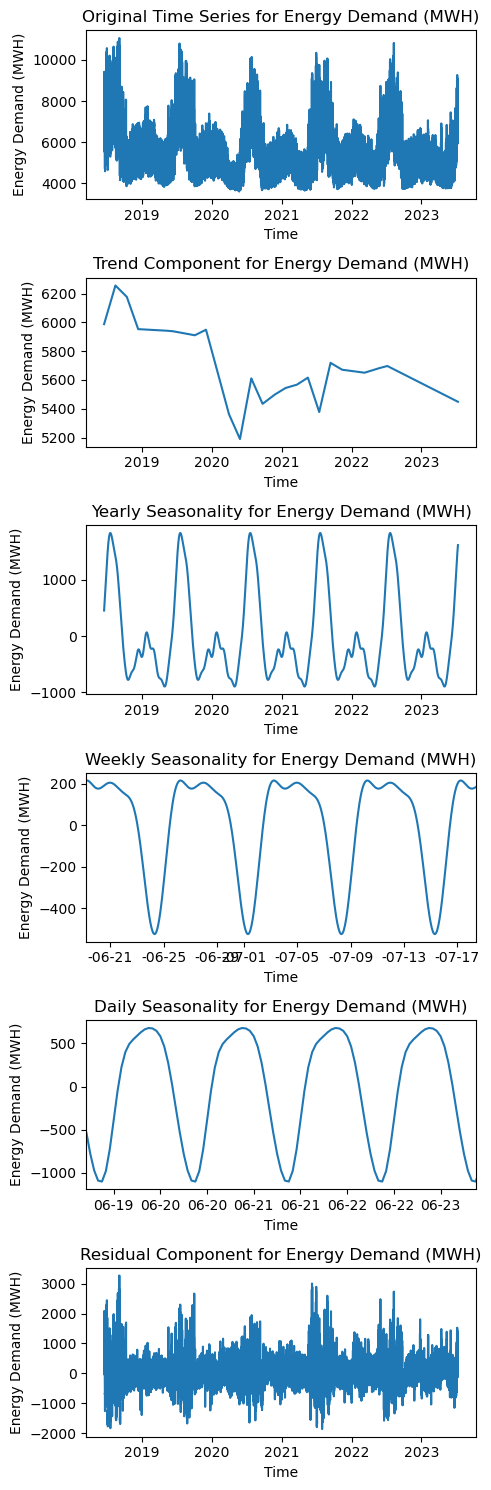

In [110]:
import seaborn as sns

# define figure
fig = plt.figure(figsize=(5,15))

# plot original time series
ax = fig.add_subplot(6,1,1)
sns.lineplot(x=forecasts["ds"].index, y=forecasts['y'])
ax.set_title("Original Time Series for {}".format(variable))
ax.set_xlabel("Time")
ax.set_ylabel(variable)

# plot trend component
ax = fig.add_subplot(6,1,2)
sns.lineplot(x = forecasts["ds"], y=forecasts["trend"])
ax.set_title("Trend Component for {}".format(variable))
ax.set_xlabel("Time")
ax.set_ylabel(variable)

# plot yearly seasonality
ax = fig.add_subplot(6,1,3)
sns.lineplot(x = forecasts["ds"], y=forecasts["yearly"])
ax.set_title("Yearly Seasonality for {}".format(variable))
ax.set_xlabel("Time")
ax.set_ylabel(variable)

# plot weekly seasonality
ax = fig.add_subplot(6,1,4)
sns.lineplot(x = forecasts["ds"], y=forecasts["weekly"])
ax.set_title("Weekly Seasonality for {}".format(variable))
ax.set_xlabel("Time")
ax.set_ylabel(variable)
# change axis limits
ax.set_xlim(forecasts["ds"].iloc[0], forecasts["ds"].iloc[100*7])
labels = [str(x)[-8:-2] for x in ax.get_xticklabels()]
ax.set_xticklabels(labels)

# plot daily seasonlity
ax = fig.add_subplot(6,1,5)
sns.lineplot(x = forecasts["ds"], y=forecasts["daily"])
ax.set_title("Daily Seasonality for {}".format(variable))
ax.set_xlabel("Time")
ax.set_ylabel(variable)
# change axis limits
ax.set_xlim(forecasts["ds"].iloc[0], forecasts["ds"].iloc[100])
labels = [str(x)[-10:-5] for x in ax.get_xticklabels()]
ax.set_xticklabels(labels)

# plot residual component
ax = fig.add_subplot(6,1,6)
sns.lineplot(x = forecasts["ds"], y=forecasts["residual"])
ax.set_title("Residual Component for {}".format(variable))
ax.set_xlabel("Time")
ax.set_ylabel(variable)

# save figure
plt.tight_layout()
fig.show()